In [1]:
import networkx as nx
import numpy as np
import random as rand
import scipy
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import os
from math import sqrt
import json
from statistics import mean
import entropy_estimators as ee


In [2]:
def get_cyclic_net(filename):
    G=nx.read_edgelist(filename, comments='#', delimiter="\t", nodetype =str,  data=(('mode',str),), create_using=nx.DiGraph())
    G.remove_nodes_from(["Source", "Target"])
    selfloops=G.selfloop_edges()
    G.remove_edges_from(G.selfloop_edges())
    
    while 0 in G.in_degree().values() or 0 in G.out_degree().values():
        nodes_to_remove=[node for node in G if G.in_degree(node) == 0 or G.out_degree(node) == 0]
        G.remove_nodes_from(nodes_to_remove)
        
    selfloops_in_reservoir=[edge for edge in selfloops if edge[0] in G.nodes()]
    G.add_edges_from(selfloops_in_reservoir)
    return G
    

In [15]:
class ESN(object):
    def __init__(self, filename, in_size, out_size, spectral_radius):
        self.res_size= self.build_adj_weighted_matrix(filename).shape[0]
        self.in_size=in_size
        self.out_size=out_size
        self.spectral_radius= spectral_radius
        self.W0=self.build_adj_weighted_matrix(filename)
        self.W=None
        self.Win=None
        self.Wout=None
        self.X=None
        self.Y=None
        self.x=np.zeros((self.res_size,1))
        self.x0=np.insert(np.random.rand(self.res_size)*10,0,[1.0,1.0,1.0])
        self.decay=np.random.rand(self.res_size,1)*5
        self.u=None
        self.x_act=None

    
    def build_adj_weighted_matrix(self, filename):
        net=get_cyclic_net(filename)
        for edge in net.edges_iter(data="mode", default=0):
            source,target,mode=edge
            if mode== "+":
                net[source][target]["weight"]= rand.uniform(0,1)
            elif mode== "-":
                net[source][target]["weight"]= rand.uniform(0,-1)
            elif mode== 0:
                net[source][target]["weight"]= rand.uniform(-1,1)
        return nx.to_numpy_matrix(net)
    
    def initialize(self): 
        np.random.seed(42)
        self.Win=np.random.choice([-0.05,0.05], size=(self.res_size,1+self.in_size))
        self.W0 = np.squeeze(np.asarray(self.W0))
        rhoW0 = max(abs(scipy.linalg.eig(self.W0)[0]))
        self.W= (self.spectral_radius/rhoW0)*self.W0
        

    def collect_states(self, data, init_len, train_len, a=0.3):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        for t in range(train_len):
            u = data[t]
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            if t >= init_len:
                self.X[:,t-init_len]= np.vstack((1,u,self.x))[:,0]
               
        return self.X
    
    def collect_states_derivative(self, a,b,c, init_len, train_len, test_len, n=0):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        t=np.arange(train_len+test_len)
        uyz_x=scipy.integrate.odeint(self.dx_dt,self.x0,t,args=(a,b,c,self.decay))
        self.u=uyz_x[:,0]
        self.x_act=uyz_x[:,3:]
        for t in range(init_len-n,train_len-n):
            x_concat=self.x_act[t,:].reshape(self.x_act[t,:].shape[0],1)
            u_concat=self.u[t]
            self.X[:,t-init_len]= np.vstack((1,u_concat,x_concat))[:,0]
               
        return self.X
    
    def dx_dt(self, uyz_x,t,a,b,c,decay):
        u=uyz_x[0]
        y=uyz_x[1]
        z=uyz_x[2]
        x=np.array(uyz_x[3:]).reshape(self.res_size,1)
       
        u=-z-y
        y=u+a*y
        z=b+z*(u-c)
        x= np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, x ) ) - np.multiply(decay,x)
        
        return np.insert(x,0,[u,y,z])
        
    
    def calculate_weights(self, data,init_len, train_len, beta=1e-8 ):
        #Y=np.array([self.u[init_len:train_len]]) #quita DATA
        Y=np.array([data[init_len:train_len]]) #PON DATA
        X_T=self.X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(self.X,X_T) + beta * np.eye(self.res_size+self.in_size+1))) #w= y*x_t*(x*x_t + beta*I)^-1
        return self.Wout
    
    def run_predictive(self, data, test_len, train_len,a=0.3):
        self.Y = np.zeros((self.out_size,test_len))
        u = data[train_len] 
        for t in range(test_len-1):
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            y = np.dot( self.Wout, np.vstack((1,u,self.x)) )
            self.Y[:,t] = y
            u = data[train_len+t+1] 
        
        return self.Y
    
    def run_predictive_derivative(self, a,b,c, test_len, train_len,dt=1):
        self.Y = np.zeros((self.out_size,test_len))
        
        for t in range(train_len,train_len+test_len):
            x_concat=self.x_act[t,:].reshape(self.x_act[t,:].shape[0],1)
            u_concat=self.u[t]
            y = np.dot( self.Wout, np.vstack((1,u_concat,x_concat)) )
            self.Y[:,t-train_len] = y
           
        
        return self.Y

In [4]:
#NARMA 
def NARMA_task(steps, data, init_len, train_len):
        Y=np.zeros(train_len)
        for t in range(init_len,train_len):
            Y[t]=0.3* Y[t-1] + 0.05*Y[t-1]*np.sum(Y[t-1:t-steps])+ 1.5*data[t-steps]*data[t-1]+0.1
                
        return Y

In [12]:
def testing_gene_net(directory,input_data,data):
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]
    print(csv_files)
    MI_by_file={}
    for file in csv_files:
        filename=file[file.index("list")+5:file.index(".csv")]
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states(input_data,initLen,trainLen)
        net.calculate_weights(input_data,initLen,trainLen)
        net.run_predictive(input_data,testLen,trainLen)
        MI_by_file[filename]=memory_capacity_n(net.Y, data,100)
        nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
        print(net.res_size, 'NRMSE = ' + str( nrmse ))
        
    return MI_by_file
        #plot( data[trainLen+1:trainLen+testLen+1], 'g' )
        #plot( net.Y.T, 'b' )
        #title('Target and generated signals $y(n)$ starting at $n=0$')
        #legend(['Target signal', 'Free-running predicted signal'])
        #show()
      


In [ ]:
def testing_gene_net_derivative(directory,a,b,c):
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]
    Y_by_file={}
    X_by_file={}
    MI_by_file={}
    for file in csv_files:
        print(file)
        filename=file[file.index("list")+5:file.index(".csv")]
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states_derivative(a,b,c,initLen,trainLen,testLen)
        net.calculate_weights(initLen,trainLen)
        net.run_predictive_derivative(a,b,c,testLen,trainLen)
        nrmse= sqrt(mean_squared_error(net.u[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
        print(net.res_size, 'NRMSE = ' + str( nrmse ))
        X_by_file[filename]=net.u
        Y_by_file[filename]=net.Y
        MI_by_file[filename]=memory_capacity_n(net.Y, net.u,100)
        print(net.res_size, " FINISHED")
    return MI_by_file, X_by_file, Y_by_file
  


In [ ]:
def testing_gene_net_file(directory,file):
    print(file)
    filename=file[file.index("list")+5:file.index(".csv")]
    net=ESN(os.path.join(directory, file),1,1,0.95)
    net.initialize()
    net.collect_states(data,initLen,trainLen)
    net.calculate_weights(data,initLen,trainLen)
    net.run_predictive(data,testLen,trainLen)
    nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
    print(net.res_size, 'NRMSE = ' + str( nrmse ))
    return memory_capacity_n(net.Y, data,100)
    

In [ ]:
def testing_gene_net_derivative_file(directory,file):
    print(file)
    filename=file[file.index("list")+5:file.index(".csv")]
    net=ESN(os.path.join(directory, file),1,1,0.95)
    net.initialize()
    net.collect_states_derivative(a,b,c,initLen,trainLen,testLen)
    net.calculate_weights(initLen,trainLen)
    net.run_predictive_derivative(a,b,c,testLen,trainLen)
    nrmse= sqrt(mean_squared_error(net.u[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
    print(net.res_size, 'NRMSE = ' + str( nrmse ))
    return memory_capacity_n(net.Y,net.u,100)

In [ ]:
def calc_MI(x, y):
    bins=sqrt(x.shape[0]/5)
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    #mi = mutual_info_score(x,y)
    return mi

In [ ]:
def calc_MI_npeet(x,y):
    return ee.mi(x.reshape((x.shape[0],1)), y.reshape((y.shape[0],1)), base=10)

In [ ]:
def memory_capacity_n(Yt, Xt,n):
    MI_i={}
    for i in range(1,2*n+1):
        MI_i[i]=calc_MI(Yt[0,300:600],Xt[300-i:600-i]) 
        
    return MI_i

In [ ]:
##################################################################################

In [ ]:
# TESTEO get_cyclic_net
G=get_cyclic_net(os.path.join("Dataset1/", "network_edge_list_modENCODE.csv"))
G.nodes()

In [ ]:
#TESTEO adjacency matrix
net=ESN(os.path.join("Dataset1/", "network_edge_list_DBTBS.csv"),1,1,0.95)
net.W0

In [ ]:
#TESTEO initialize
net.initialize()
print(net.W.shape)
print(max(abs(scipy.linalg.eig(net.W)[0])))

In [ ]:
##################################################################################

In [8]:
# TRAINING AND TEST LENGHT
errorLen = 500
trainLen=5000
testLen=1000
initLen=100

#Files
csv_files=['network_edge_list_ENCODE.csv', 'network_edge_list_modENCODE.csv', 'network_edge_list_YEASTRACT.csv', 'network_edge_list_EcoCyc.csv', 'network_edge_list_DBTBS.csv']

#parameters ROSSLER
a=0.25
b=0.20
c=5.7

In [ ]:
####################################################################################

In [6]:
#MACKEY GLASS
data = np.loadtxt('MackeyGlass_t17.txt')

MACKEY GLASS
207 NRMSE = 0.0676924277911836


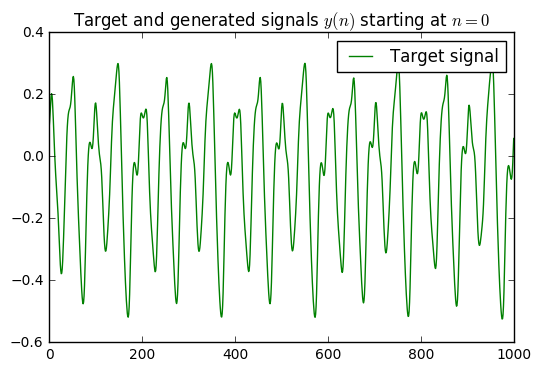

486 NRMSE = 0.06769213702365964


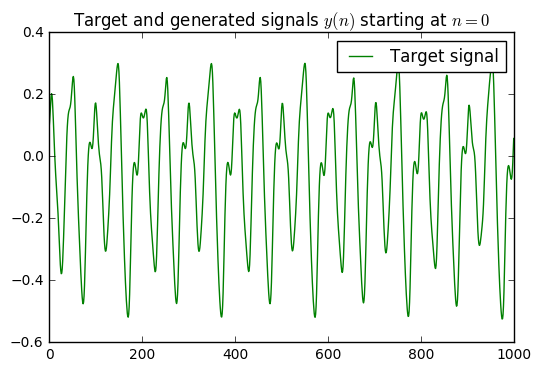

289 NRMSE = 0.06769662192695762


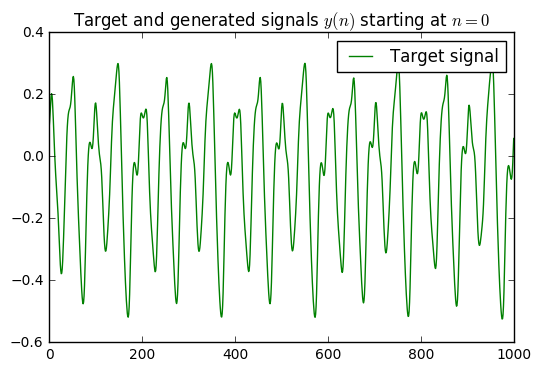

70 NRMSE = 0.06769597039178687


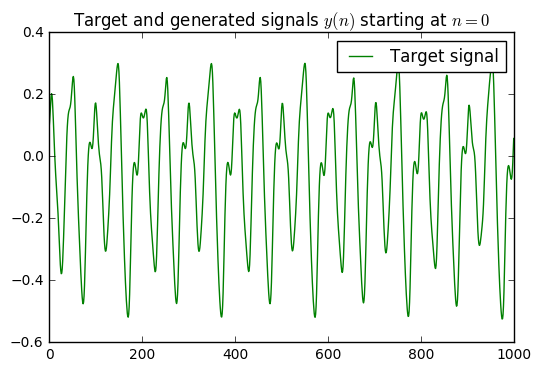

13 NRMSE = 0.06769683507747826


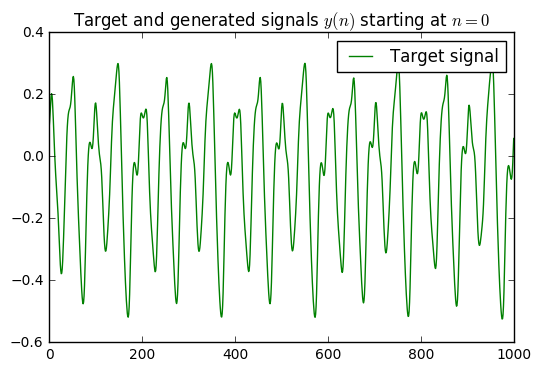

In [13]:
print("MACKEY GLASS")
MI=testing_gene_net("Dataset1/",data)

In [ ]:
for key, value in MI["DBTBS"].items():
    print(MI["DBTBS"][key]==MI["YEASTRACT"][key])

In [ ]:
print("MACKEY GLASS")
testing_gene_net("Dataset1/",data,data)

In [ ]:
print(testing_gene_net_file("Dataset1/", csv_files[0])[1])
print(testing_gene_net_file("Dataset1/", csv_files[1])[1])

In [ ]:
testing_gene_net_derivative_file("Dataset1/",csv_files[4])

In [ ]:
##################################################################################

In [ ]:
rand.uniform(-1,0)

In [ ]:
# NARMA TASK

In [10]:
u_narma= [rand.uniform(0,0.5) for el in range(10501)]
NARMA_result= NARMA_task(10,u_narma,initLen,len(data))
NARMA_result[2000:4000]


array([ 0.3805341 ,  0.26553671,  0.35492398, ...,  0.22025762,
        0.21846962,  0.21918242])

NARMA
207 NRMSE = 0.3537393258107234


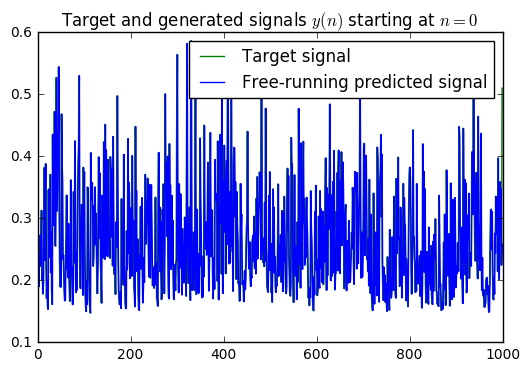

486 NRMSE = 0.35373838785381145


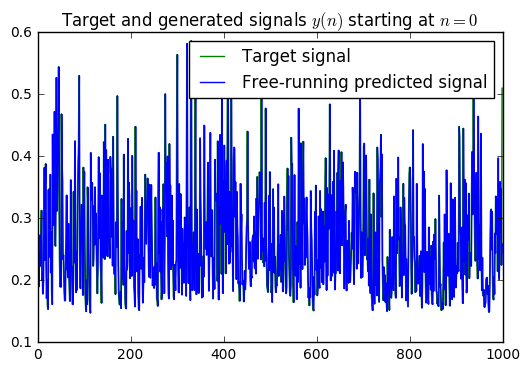

289 NRMSE = 0.3537381120197135


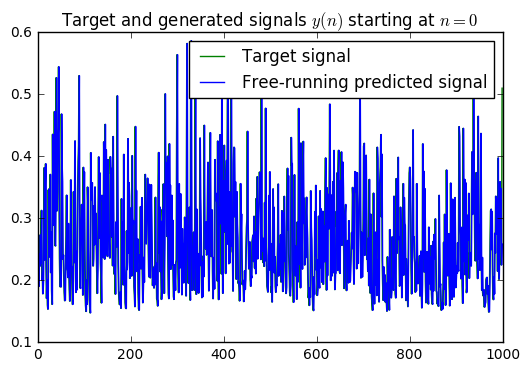

70 NRMSE = 0.3537389471773949


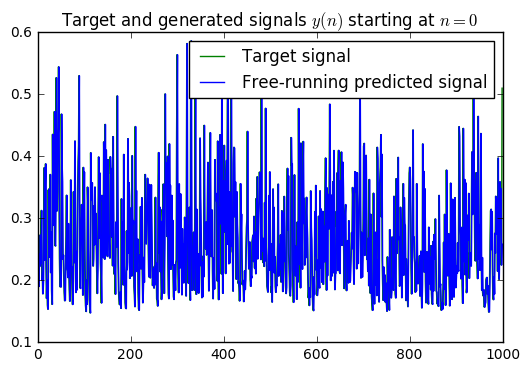

13 NRMSE = 0.3537385315324013


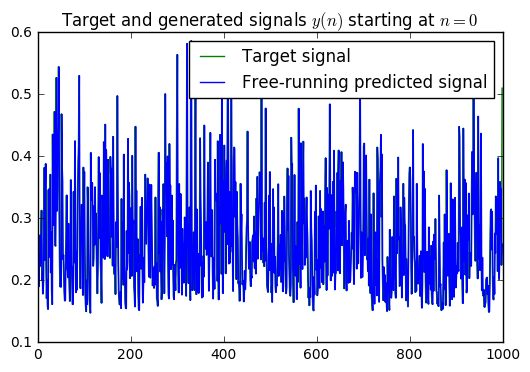

In [11]:
print("NARMA")
testing_gene_net("Dataset1/",NARMA_result)

In [ ]:
###################################

In [ ]:
print("With derivatives")
MI_by_file, X_by_file, Y_by_file=testing_gene_net_derivative("Dataset1/", a,b,c)

In [ ]:
MI_by_file

In [ ]:
ee.vectorize([1,2,3])

In [ ]:
from math import log,pi
list(map(log,[1,2,3]))